In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="VWBTrsiQOWQacmTwHIbb")
project = rf.workspace("social-interaction").project("products-qplqa")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to products-1 in yolov8:: 100%|██████████| 11606/11606 [00:02<00:00, 5472.34it/s]


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Set paths to dataset
dataset_path = "/content/products-1"
train_images_path = os.path.join(dataset_path, "train", "images")
train_labels_path = os.path.join(dataset_path, "train", "labels")
valid_images_path = os.path.join(dataset_path, "valid", "images")
valid_labels_path = os.path.join(dataset_path, "valid", "labels")
test_images_path = os.path.join(dataset_path, "test", "images")
test_labels_path = os.path.join(dataset_path, "test", "labels")

# Function to load data
def load_data(images_path, labels_path, img_size=(224, 224)):
    images = []
    labels = []

    image_files = sorted(os.listdir(images_path))
    label_files = sorted(os.listdir(labels_path))

    for image_file, label_file in zip(image_files, label_files):
        # Load and resize image
        img = load_img(os.path.join(images_path, image_file), target_size=img_size)
        img = img_to_array(img)
        images.append(img)

        # Read label file and extract class IDs
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            class_ids = []
            for line in lines:
                parts = line.strip().split()
                class_id = int(parts[0])  # Extract class ID
                class_ids.append(class_id)
            labels.append(class_ids)

    images = np.array(images)
    labels = np.array(labels, dtype=object)  # Handling multiple labels per image

    return images, labels

# Load training, validation, and testing data
img_size = (224, 224)
train_images, train_labels = load_data(train_images_path, train_labels_path, img_size)
valid_images, valid_labels = load_data(valid_images_path, valid_labels_path, img_size)
test_images, test_labels = load_data(test_images_path, test_labels_path, img_size)

# Normalize images
train_images = train_images.astype('float32') / 255.0
valid_images = valid_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to binary indicators for multi-label classification
NUM_CLASSES = 10  # Adjust based on your dataset
def convert_to_multi_label(labels, num_classes):
    multi_label = np.zeros((len(labels), num_classes))
    for i, label_list in enumerate(labels):
        for label in label_list:
            multi_label[i][label] = 1  # Set the class to 1
    return multi_label

train_labels_binary = convert_to_multi_label(train_labels, NUM_CLASSES)
valid_labels_binary = convert_to_multi_label(valid_labels, NUM_CLASSES)
test_labels_binary = convert_to_multi_label(test_labels, NUM_CLASSES)

# Define the CNN model
def create_cnn_model(input_shape=(224, 224, 3), num_classes=10):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output for the fully connected layer
    model.add(layers.Flatten())

    # Fully connected Layer 1
    model.add(layers.Dense(512, activation='relu'))

    # Output Layer with sigmoid activation for multi-label classification
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    # Compile the model for multi-label classification
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create and summarize the model
model = create_cnn_model(input_shape=(224, 224, 3), num_classes=NUM_CLASSES)
model.summary()

# Train the model
history = model.fit(
    train_images, train_labels_binary,
    epochs=15,
    batch_size=32,
    validation_data=(valid_images, valid_labels_binary)
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels_binary, verbose=2)
print(f"Test accuracy: {test_acc}")

# Save the model
model.save('/content/drive/MyDrive/product_updated_cnn_model.h5')


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,401,226 (169.38 MB)

 Trainable params: 44,401,226 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 31s 142ms/step - accuracy: 0.5021 - loss: 0.2951 - val_accuracy: 0.9125 - val_loss: 0.0275
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9081 - loss: 0.0266 - val_accuracy: 0.9375 - val_loss: 0.0093
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9318 - loss: 0.0052 - val_accuracy: 0.9604 - val_loss: 0.0057
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9342 - loss: 0.0049 - val_accuracy: 0.9271 - val_loss: 0.0064
Epoch 5/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9278 - loss: 0.0085 - val_accuracy: 0.9062 - val_loss: 0.0085
Epoch 6/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9258 - loss: 0.0033 - val_accuracy: 0.8917 - val_loss: 0.0072
Epoch 7/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9433 - loss: 0.0025 - val_accuracy: 0.9000 - val_loss: 0.0123
Epoch 8/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9275 - loss: 0.0024 - val

Test accuracy: 0.9240506291389465


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


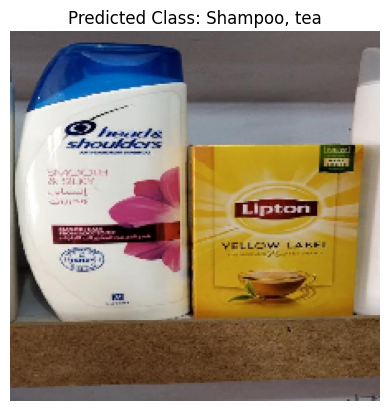

Predicted Classes: ['Shampoo', 'tea']


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/product_updated_cnn_model.h5')

# Function to preprocess a single image
def preprocess_image(image_path, img_size=(224, 224)):
    # Load the image
    img = load_img(image_path, target_size=img_size)

    # Convert to array
    img_array = img_to_array(img)

    # Normalize the image
    img_array = img_array.astype('float32') / 255.0

    # Expand dimensions to match the model's input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array, img  # Return both preprocessed image and original image

# Class labels (Adjust as per your dataset)
CLASS_NAMES =['Cooking Oil', 'Dishwash liquid', 'Fruit Jam', 'Lays Chips', 'Shampoo', 'Soya Sauce', 'Toilet Cleaner', 'Tomato Ketchup', 'dettol liquid', 'tea']

# Function to make predictions
def predict_image(image_path):
    # Preprocess the image
    preprocessed_image, original_image = preprocess_image(image_path)

    # Predict probabilities for each class
    predictions = model.predict(preprocessed_image)

    # Threshold for multi-label classification
    threshold = 0.5  # Adjust as needed

    # Get class labels for probabilities above the threshold
    predicted_classes = [CLASS_NAMES[i] for i, prob in enumerate(predictions[0]) if prob > threshold]

    return predicted_classes, original_image

# Test the model with a single image
image_path = "/content/products-1/test/images/13_mp4-0008_jpg.rf.1b806bd6cd3f9deb0e5ecb231a588846.jpg"  # Replace with the path to your test image
predicted_classes, original_image = predict_image(image_path)

# Plot the image and display the predicted class name
plt.imshow(original_image)  # Display the original image
plt.title(f"Predicted Class: {', '.join(predicted_classes)}")  # Display predicted class name
plt.axis('off')  # Hide axis
plt.show()

print(f"Predicted Classes: {predicted_classes}")


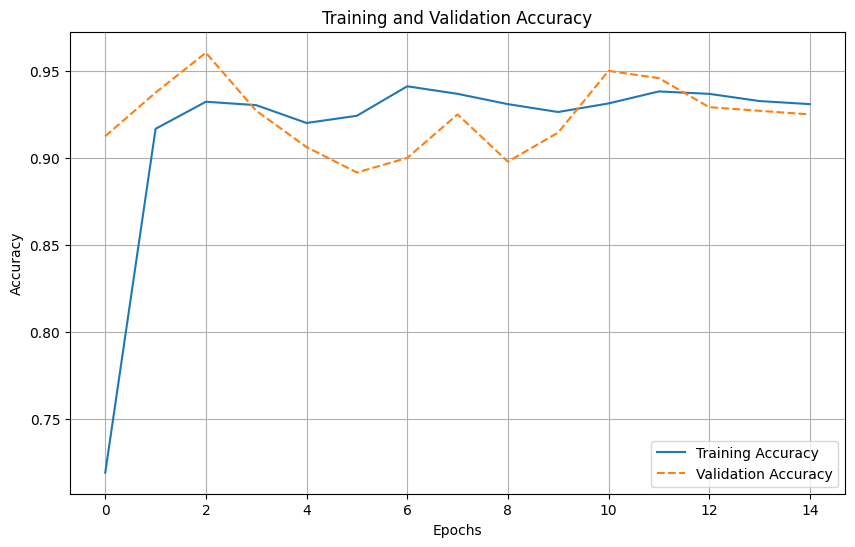

In [7]:
import matplotlib.pyplot as plt


# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1000x800 with 0 Axes>

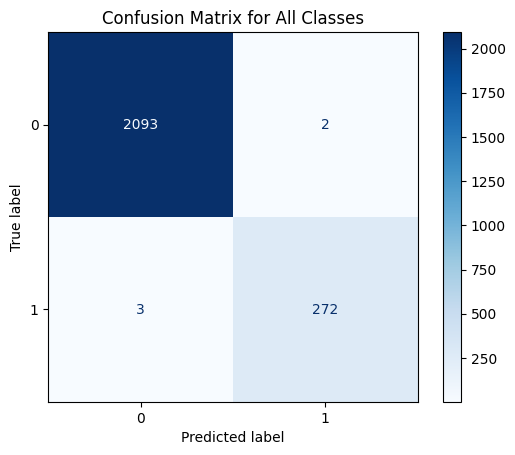

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get ground truth and predictions
y_true = test_labels_binary  # Ground truth: binary matrix (1 if class is present, else 0)
y_pred = (model.predict(test_images) > 0.5).astype(int)  # Binary predictions (threshold 0.5)

# Flatten the ground truth and predictions for all classes
y_true_flattened = y_true.flatten()
y_pred_flattened = y_pred.flatten()

# Generate the confusion matrix for all classes combined
cm = confusion_matrix(y_true_flattened, y_pred_flattened)

# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for All Classes')
plt.show()
